# Notebook to recreate Figs. 1C and 1D from Alex et al.

# Fig. 1C--Simulations for the two-state promoter for HIV

### Load the required packages

In [11]:
library(Matrix)
library(GillespieSSA2)
library(doSNOW)
library(foreach)
library(ggpubr)
library(cowplot)
library(scales)
library(latex2exp)

### Create cluster to use foreach for parallel computation

In [2]:
num_cores = 10 # num. of cores to use
nboot <- 1000 # num. of cells to simulate
cl <- makeCluster(num_cores) # create clusters
registerDoSNOW(cl) # register clusters
# clusterEvalQ(cl, .libPaths("/home/atheistpoet/R/x86_64-pc-linux-gnu-library/4.0"))
clusterCall(cl, function() {
    lib.path <- "/home/atheistpoet/R/x86_64-pc-linux-gnu-library/4.0" # R library path
    .libPaths(lib.path) 
    library(GillespieSSA2)
})
pb <- txtProgressBar(max = nboot, style = 3) # to display progress bars for parallel computation
progress <- function(n) setTxtProgressBar(pb, n) # to display progress bars for parallel computation
opts <- list(progress = progress) # to display progress bars for parallel computation

[[1]]
[1] "GillespieSSA2" "snow"          "stats"         "graphics"     
[5] "grDevices"     "utils"         "datasets"      "methods"      
[9] "base"         

[[2]]
[1] "GillespieSSA2" "snow"          "stats"         "graphics"     
[5] "grDevices"     "utils"         "datasets"      "methods"      
[9] "base"         

[[3]]
[1] "GillespieSSA2" "snow"          "stats"         "graphics"     
[5] "grDevices"     "utils"         "datasets"      "methods"      
[9] "base"         

[[4]]
[1] "GillespieSSA2" "snow"          "stats"         "graphics"     
[5] "grDevices"     "utils"         "datasets"      "methods"      
[9] "base"         

[[5]]
[1] "GillespieSSA2" "snow"          "stats"         "graphics"     
[5] "grDevices"     "utils"         "datasets"      "methods"      
[9] "base"         

[[6]]
[1] "GillespieSSA2" "snow"          "stats"         "graphics"     
[5] "grDevices"     "utils"         "datasets"      "methods"      
[9] "base"         

[[7]]
[1] "GillespieSSA2" "snow"          "stats"         "graphics"     
[5] "grDevices"     "utils"         "datasets"      "methods"      
[9] "base"         

[[8]]
[1] "GillespieSSA2" "snow"          "stats"         "graphics"     
[5] "grDevices"     "utils"         "datasets"      "methods"      
[9] "base"         

[[9]]
[1] "GillespieSSA2" "snow"          "stats"         "graphics"     
[5] "grDevices"     "utils"         "datasets"      "methods"      
[9] "base"         

[[10]]
[1] "GillespieSSA2" "snow"          "stats"         "graphics"     
[5] "grDevices"     "utils"         "datasets"      "methods"      
[9] "base"

  |                                                                      |   0%

## List to store all the plots for Fig. 1C

In [3]:
plot.list <- list()

## Simulations for the untreated case

### Setup simulation parameters and initial state

In [4]:
# reaction rates (k_on, k_off, k_m, gamma_m, k_p, gamma_p)
rxn_rates = c(0.000208333, 0.002083333, 0.208333333, 0.000115525, 0.032346868, 7.70164E-05) 

params <- c(kon = rxn_rates[1], koff = rxn_rates[2], km = rxn_rates[3], 
                   gamma_m = rxn_rates[4], kp = rxn_rates[5], gamma_p = rxn_rates[6])

# initial state vector
initial_state <- c(Gon = 1, Goff = 0,  
            M = floor((rxn_rates[1] * rxn_rates[3])/
                      ((rxn_rates[1] + rxn_rates[2]) * rxn_rates[4])), 
            P = floor((rxn_rates[5])/rxn_rates[6])*
              floor((rxn_rates[1] * rxn_rates[3])/
                      ((rxn_rates[1] + rxn_rates[2]) * rxn_rates[4])))

# reactions in the system
reactions <- list(reaction(~kon * Goff, c(Goff = -1, Gon = +1), "promoter_on"),  
                  reaction(~koff * Gon, c(Goff = +1, Gon = -1), "promoter_off"), 
                  reaction(~km * Gon, c(M = +1), "transcription"), 
                  reaction(~gamma_m * M, c(M = -1), "mRNA_degradation"), 
                  reaction(~kp * M, c(P = +1), "translation"), 
                  reaction(~gamma_p * P, c(P = -1), "protein_degradation"))

# num. of hours of simulation to use as burn-in
skip_hours <- 10

### Run simulation using Gillespie's Direct Method (DM)

In [5]:
out.control <- foreach( b = 1:nboot, .options.snow = opts )%dopar%{
  set.seed(b)
#   library(doParallel)
#   library(GillespieSSA2)
  out <-
    ssa(
      initial_state = initial_state,
      reactions = reactions,
      params = params,
      method = ssa_exact(),
      final_time = (20 + skip_hours) * 60 * 60,
      census_interval = 10,
      verbose = TRUE
    )
  return(list(time = out$time, Protein = out$state[, 4], promoter = out$state[, 1]))
}
save(out.control, file = "time_series_untreated_Fig1C.RData")

  |======================================================================| 100%

### Extract single-cell protein counts at the end of the simulation. Take all single-cell data from all time points; assume that the process is ergodic.

In [6]:
steady_state <- rep(0, nboot)
for( i in 1:nboot ){
  steady_state[i] <- out.control[[i]]$Protein[length(out.control[[i]]$Protein)]
}
mean_val <- mean(steady_state) # steady-state mean for the untreated control

### Plot for single-cell trajectories protein count for untreated

In [52]:
col <- "gray20" # color for the single-cell time trajectories
skip_hours <- 10
# Plot gray region showing threshold region for active HIV replication
dat.polygon <- data.frame(x = c(0, 20, 20, 0), 
                          y = c(3, 3, 4.5, 4.5))
p <- ggplot()
p <- p + geom_polygon(aes(x = x, y = y), data = dat.polygon, fill = "gray", 
                      col = "white", alpha = 0.5) + 
  geom_text(data = data.frame(x = 10, y = 3.7, label = "Active \n replication"), 
            mapping = aes(x = x, y = y, label = label), color = "black", size = 5)

#Add all the time trajectors to the plot
id.sample <- 1:nboot
for( b in id.sample ){
  id <- which(out.control[[b]]$time >= skip_hours * 60 * 60)
  dat.plot <- data.frame(x = out.control[[b]]$time[id]/(60 * 60) - 
                           min(out.control[[1]]$time[id]/(60 * 60)), 
                         y = out.control[[b]]$Protein[id]/10^5)
  p <- p + geom_line(data = dat.plot, mapping = aes(x = x, y = y), color = col, 
                     linetype = 1, size = 0.3)
}

# Add horizontal line for the mean value
p <- p + geom_hline(yintercept = mean_val/10^5, color = "gray", linetype = 2, 
                    size = 1.3)

# Write 'Mean' above the mean horizontal line
p <- p + 
geom_text(data = data.frame(x = 10, y = 1, label = "Mean"), 
            mapping = aes(x = x, y = y, label = label), color = "white", size = 5)

# Remove white space between the plot and the axes
p <- p + ylim(c(0, 4.5)) + 
  scale_x_continuous(limits = c(0,20), expand = c(0, 0)) +
  scale_y_continuous(limits = c(0,4.5), expand = c(0, 0))

# Add axes labels
p <- p + xlab("Time (hrs)") + ylab(expression(atop("Gene product", 
                                   "(molecules" %*% "10"^"5"*")")))

# Adjust font sizes for the title and the axes
p <- p + 
  theme(plot.title = element_text(size = 16, color = "black", face="bold.italic"), 
        axis.title.x = element_text(size = 14, colour = "black", face = "bold"), 
        axis.title.y = element_text(size = 14, colour = "black", face = "bold"), 
        axis.text.x = element_text(size = 13, colour = "black"), 
        axis.text.y = element_text(size = 13, colour = "black"), 
        panel.background = element_blank(), 
        axis.line.y = element_line(color = "black"), axis.line.x = element_line(color = "black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank())
p.control.time <- p +  ggtitle("Untreated")

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



### Histogram for protein count at the end of simulation

In [53]:
# y-axis limit
ymax <- 80
ymid <- 40

# Draw a gray region which defines region of active HIV replication
dat.polygon <- data.frame(y = c(0, ymax, ymax, 0), 
                          x = c(3, 3, 4.5, 4.5))
p <- ggplot() + geom_polygon(aes(x = x, y = y), data = dat.polygon, fill = "gray", 
                      col = "white", alpha = 0.5)

# Save single-cell protein count data at the end of simulation in a data frame
dat.plot <- data.frame(x = steady_state/10^5)

# Plot histogram
p <- p + 
  geom_histogram(data = dat.plot, mapping = aes(x = x),
                 color="black", fill="black", bins = 100) + coord_flip()

# Remove white space between the plot and the axes
p <- p + xlim(c(0, 4.5)) + 
  scale_x_continuous(limits = c(0,4.5), expand = c(0, 0)) + 
  scale_y_continuous(limits = c(0,ymax), expand = c(0, 0))

# Remove background and axes text
p <- p + 
  theme(axis.title.x = element_blank(), 
        axis.title.y = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_blank(), 
        axis.ticks.x = element_blank(), 
        axis.ticks.y = element_blank(), 
        panel.background = element_blank(), axis.line.y = element_line(), 
        panel.grid.major = element_blank(), panel.grid.minor = element_blank())

# Add horizontal line for the mean value
p <- p + geom_vline(xintercept = mean(steady_state)/10^5, color = "gray", linetype = 2, 
                    size = 1.3)

# Visually explain the concept of noise
p <- p + geom_segment(aes(x = 0, y = ymid, 
                          xend = 0.3, yend = ymid),
                      arrow = arrow(length = unit(0.3, "cm")), size = 0.7)
p <- p + geom_segment(aes(x = 1.3, y = ymax/2, 
                          xend = 1, yend = ymid),
                      arrow = arrow(length = unit(0.3, "cm")), size = 0.7) + 
  geom_text(data = data.frame(x = 1.5, y = ymid, label = "Noise"), 
            mapping = aes(x = x, y = y, label = label), color = "black", size = 5)
p.control.hist <- p

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



### Representative plot of promoter activity

<ScaleContinuousPosition>
 Range:  
 Limits:    0 --   20

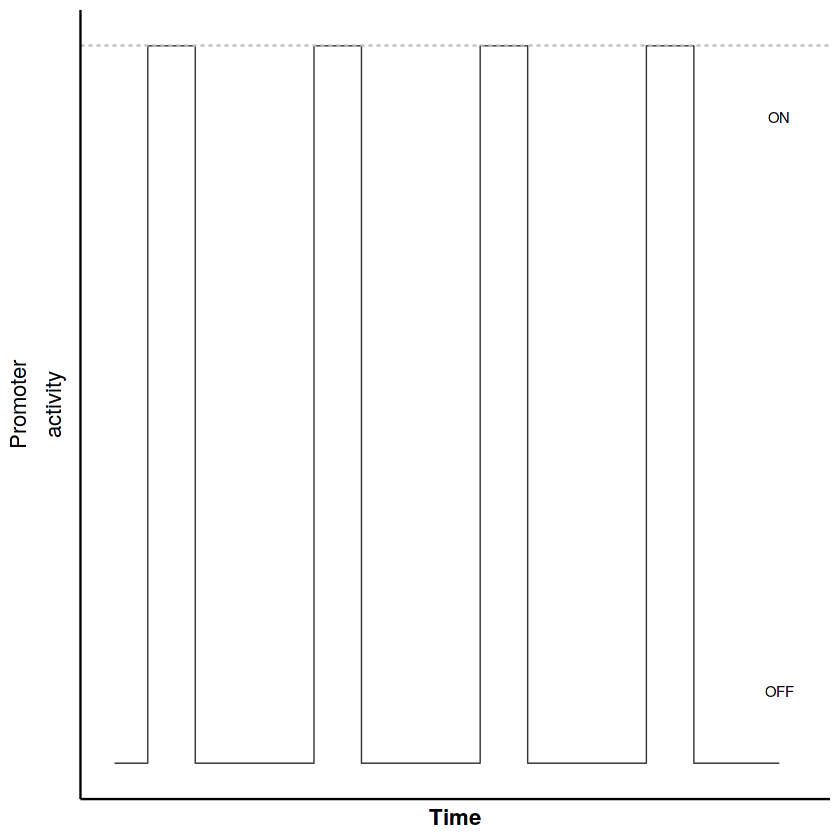

In [54]:
col <- "gray20"
params = c(kon = 1/(5*3600), koff = 1/(2*3600))
on_frac = (params['kon'])/(params['kon'] + params['koff'])
on_time <- 1/(params['kon'] + params['koff'])
time_diff <- 1/(params['kon'])
num_bursts <- floor((20*3600)/time_diff)
burst_times <- 3600 + (1:num_bursts - 1)*(1/(params['kon']))
time_list <- seq(0, 20*3600, by = 1)
promoter <- rep(0, 20*3600 + 1)
for( b in 1:num_bursts ){
    id.begin <- which(time_list >= burst_times[b])
    id.end <- which(time_list <= burst_times[b] + on_time)
    if( length(id.end) != 0 ){
        promoter[id.begin[1]:id.end[length(id.end)]] <- 1
    }else{
        promoter[id.begin[1]:(20*3600 + 1)] <- 1
    }
    
}
dat.plot <- data.frame(x = time_list/3600, 
                        y = promoter)
p <- ggline(dat.plot, x = "x", y = "y", 
            numeric.x.axis = T, 
            linetype = "solid",
            plot_type = c("l"),
            fill = col,           
            color = col,
            sort.by.groups = FALSE,
            x.text.angle = 0,
            ylab = expression(atop("Promoter", 
                                   "activity")),
            xlab = "Time",
            # legend = "bottom",
            legend.title = "",
            y.text.angle = 0,
            rotate = F,
            font.x = 14, 
            font.y = 14,
            font.tickslab = 13,
            size = 0.3,
            point.size = 0.1,
            # font.label = 14,
            theme = theme_pubr()
)
# Add horizontal line for the mean value
p <- p + geom_hline(yintercept = 1, color = "gray", linetype = 2, 
                    size = 0.5)

p <- p  + 
  geom_text(data = data.frame(x = 20, y = 0.9, label = "ON"), 
            mapping = aes(x = x, y = y, label = label), color = "black", size = 3) + 
geom_text(data = data.frame(x = 20, y = 0.1, label = "OFF"), 
            mapping = aes(x = x, y = y, label = label), color = "black", size = 3)

# Remove white space between the plot and the axes
p <- p + xlim(c(0, 20.5))
  scale_x_continuous(limits = c(0,20), expand = c(0, 0))

# Adjust font sizes for the title and the axes
p <- p + 
  theme(plot.title = element_text(size = 15, color = "black", face="bold.italic"), 
        axis.title.x = element_text(size = 13, colour = "black", face = "bold"), 
        axis.title.y = element_text(size = 13, colour = "black", face = "bold"), 
        axis.text.x = element_blank(),
        axis.text.y = element_blank(), 
        axis.ticks.x = element_blank(), 
        axis.ticks.y = element_blank())
p.control.promoter <- p
print(p)

### Combine plots

In [ ]:
first.row <- plot_grid(p.control.time, p.control.hist, ncol = 2, 
                    labels = "", align = "h", rel_widths = c(1.6, 1))
second.row <- plot_grid(p.control.promoter, NULL, ncol = 2, labels = "", align = "h", 
                       rel_widths = c(1.6, 1))
plot.control <- plot_grid(first.row, second.row, nrow = 2, rel_heights = c(2.5, 1))
save_plot("Plot_untreated.png", plot.control, base_height = 4, base_width = 6)
# print(plot.control)
plot.list[[1]] <- plot.control

## Simulations for noise enhancer

### Setup simulation parameters and initial state

In [73]:
# reaction rates (k_on, k_off, k_m, gamma_m, k_p, gamma_p)
rxn_rates = c(0.000104167, 0.001041667, 0.208333333, 0.000115525, 0.032346868, 7.70164E-05) 

params <- c(kon = rxn_rates[1], koff = rxn_rates[2], km = rxn_rates[3], 
                   gamma_m = rxn_rates[4], kp = rxn_rates[5], gamma_p = rxn_rates[6])

# initial state vector
# initial_state <- c(Gon = 1, Goff = 0,  
#             M = floor((rxn_rates[1] * rxn_rates[3])/
#                       ((rxn_rates[1] + rxn_rates[2]) * rxn_rates[4])), 
#             P = floor((rxn_rates[5])/rxn_rates[6])*
#               floor((rxn_rates[1] * rxn_rates[3])/
#                       ((rxn_rates[1] + rxn_rates[2]) * rxn_rates[4])))

# reactions in the system
reactions <- list(reaction(~kon * Goff, c(Goff = -1, Gon = +1), "promoter_on"),  
                  reaction(~koff * Gon, c(Goff = +1, Gon = -1), "promoter_off"), 
                  reaction(~km * Gon, c(M = +1), "transcription"), 
                  reaction(~gamma_m * M, c(M = -1), "mRNA_degradation"), 
                  reaction(~kp * M, c(P = +1), "translation"), 
                  reaction(~gamma_p * P, c(P = -1), "protein_degradation"))

# num. of hours of simulation to use as burn-in
skip_hours <- 0

### Run simulation using Gillespie's Direct Method (DM)

In [13]:
out.NE <- foreach( b = 1:nboot, .options.snow = opts )%dopar%{
  set.seed(b)
  library(doParallel)
  library(GillespieSSA2)
  initial_state <- c(Gon = 1, Goff = 0,  
            M = floor((rxn_rates[1] * rxn_rates[3])/
                      ((rxn_rates[1] + rxn_rates[2]) * rxn_rates[4])), 
            P = out.control[[b]]$Protein[length(out.control[[b]]$Protein)])  
    
  out <-
    ssa(
      initial_state = initial_state,
      reactions = reactions,
      params = params,
      method = ssa_exact(),
      final_time = (20 + skip_hours) * 60 * 60,
      census_interval = 10,
      verbose = TRUE
    )
  return(list(time = out$time, Protein = out$state[, 4]))
}
save(out.NE, file = "time_series_noise_enhancer_Fig1C.RData")

  |======================================================================| 100%

### Extract single-cell protein counts at the end of the simulation. Take all single-cell data from all time points; assume that the process is ergodic.

In [74]:
steady_state <- rep(0, nboot)
for( i in 1:nboot ){
  steady_state[i] <- out.NE[[i]]$Protein[length(out.NE[[i]]$Protein)]
}

### Plot for single-cell trajectories protein count

In [75]:
col <- "purple" # color for the single-cell time trajectories
skip_hours <- 0
# Plot gray region showing threshold region for active HIV replication
dat.polygon <- data.frame(x = c(0, 20, 20, 0), 
                          y = c(3, 3, 4.5, 4.5))
p <- ggplot()
p <- p + geom_polygon(aes(x = x, y = y), data = dat.polygon, fill = "gray", 
                      col = "white", alpha = 0.5) 
# + 
#   geom_text(data = data.frame(x = 10, y = 4, label = "Active \n replication"), 
#             mapping = aes(x = x, y = y, label = label), color = "white", size = 5)

#Add all the time trajectors to the plot
id.sample <- 1:nboot
for( b in id.sample ){
  id <- which(out.NE[[b]]$time >= skip_hours * 60 * 60)
  dat.plot <- data.frame(x = out.NE[[b]]$time[id]/(60 * 60) - 
                           min(out.NE[[1]]$time[id]/(60 * 60)), 
                         y = out.NE[[b]]$Protein[id]/10^5)
  p <- p + geom_line(data = dat.plot, mapping = aes(x = x, y = y), color = col, 
                     linetype = 1, size = 0.3)
}

# Add horizontal line for the mean value
p <- p + geom_hline(yintercept = mean_val/10^5, color = "gray", linetype = 2, 
                    size = 1.3)

# Write 'Mean' above the mean horizontal line
p <- p + 
geom_text(data = data.frame(x = 10, y = 1, label = "Mean"), 
            mapping = aes(x = x, y = y, label = label), color = "white", size = 5)

# Remove white space between the plot and the axes
p <- p + ylim(c(0, 4.5)) + 
  scale_x_continuous(limits = c(0,20), expand = c(0, 0)) +
  scale_y_continuous(limits = c(0,4.5), expand = c(0, 0))

# Add axes labels
p <- p + xlab("Time (hrs)") + ylab(expression(atop("Gene product", 
                                   "(molecules" %*% "10"^"5"*")")))

# Adjust font sizes for the title and the axes
p <- p + 
  theme(plot.title = element_text(size = 16, color = "black", face="bold.italic"), 
        axis.title.x = element_text(size = 14, colour = "black", face = "bold"), 
        axis.title.y = element_text(size = 14, colour = "black", face = "bold"), 
        axis.text.x = element_text(size = 13, colour = "black"), 
        axis.text.y = element_text(size = 13, colour = "black"), 
        panel.background = element_blank(),
        axis.line.y = element_line(color = "black"), axis.line.x = element_line(color = "black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank())
p.NE.time <- p +  ggtitle("Noise enhancer")

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



### Histogram for protein count at the end of simulation

In [76]:
# y-axis limit
col <- "purple"
ymax <- 100
ymid <- 40

# Draw a gray region which defines region of active HIV replication
dat.polygon <- data.frame(y = c(0, ymax, ymax, 0), 
                          x = c(3, 3, 4.5, 4.5))
p <- ggplot() + geom_polygon(aes(x = x, y = y), data = dat.polygon, fill = "gray", 
                      col = "white", alpha = 0.5)

# Save single-cell protein count data at the end of simulation in a data frame
dat.plot <- data.frame(x = steady_state/10^5)

# Plot histogram
p <- p + 
  geom_histogram(data = dat.plot, mapping = aes(x=x), color=col, fill=col, bins = 50) + coord_flip()

# Remove white space between the plot and the axes
p <- p + xlim(c(0, 4.5)) + 
  scale_x_continuous(limits = c(0,4.5), expand = c(0, 0)) + 
  scale_y_continuous(limits = c(0,ymax), expand = c(0, 0))

# Remove background and axes text
p <- p + 
  theme(axis.title.x = element_blank(), 
        axis.title.y = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_blank(), 
        axis.ticks.x = element_blank(), 
        axis.ticks.y = element_blank(), 
        panel.background = element_blank(), axis.line.y = element_line(), 
        panel.grid.major = element_blank(), panel.grid.minor = element_blank())

# Add horizontal line for the mean value
p <- p + geom_vline(xintercept = mean_val/10^5, color = "gray", linetype = 2, 
                    size = 1.3)



# Visually explain the concept of noise
# p <- p + geom_segment(aes(x = 0, y = ymid, 
#                           xend = 0.3, yend = ymid),
#                       arrow = arrow(length = unit(0.3, "cm")), size = 0.7)
# p <- p + geom_segment(aes(x = 1.3, y = ymid, 
#                           xend = 1, yend = ymid),
#                       arrow = arrow(length = unit(0.3, "cm")), size = 0.7) + 
#   geom_text(data = data.frame(x = 1.5, y = ymid, label = "Noise"), 
#             mapping = aes(x = x, y = y, label = label), color = "black", size = 5)
p.NE.hist <- p

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



### Representative plot of promoter activity

<ScaleContinuousPosition>
 Range:  
 Limits:    0 --   20

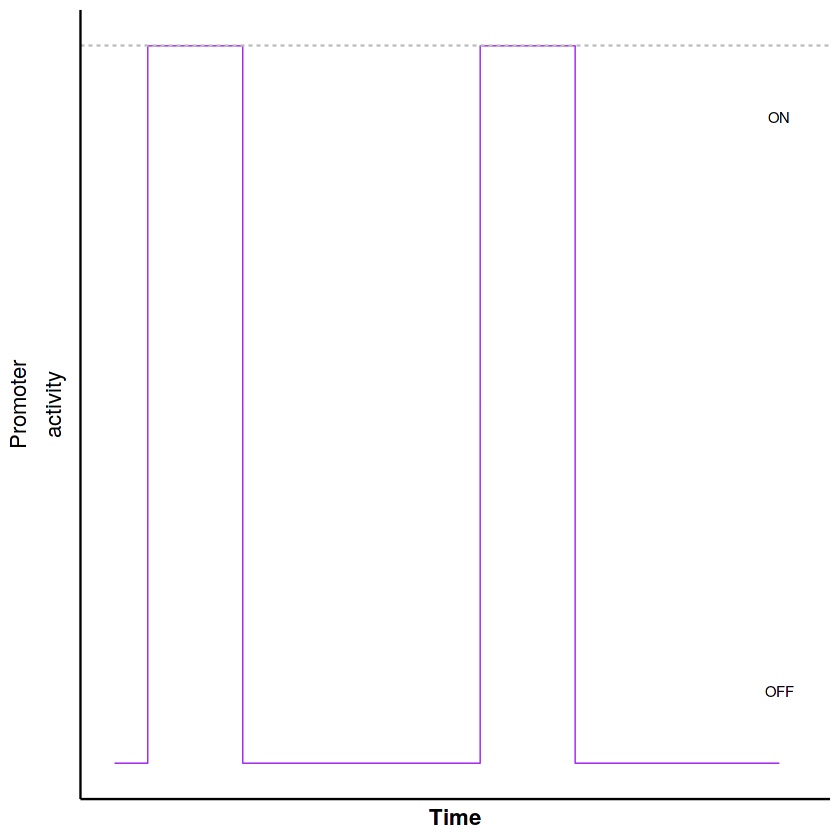

In [78]:
col <- "purple"
params = c(kon = 0.5/(5*3600), koff = 0.5/(2*3600))
on_frac = (params['kon'])/(params['kon'] + params['koff'])
on_time <- 1/(params['kon'] + params['koff'])
time_diff <- 1/(params['kon'])
num_bursts <- floor((20*3600)/time_diff)
burst_times <- 3600 + (1:num_bursts - 1)*(1/(params['kon']))
time_list <- seq(0, 20*3600, by = 1)
promoter <- rep(0, 20*3600 + 1)
for( b in 1:num_bursts ){
    id.begin <- which(time_list >= burst_times[b])
    id.end <- which(time_list <= burst_times[b] + on_time)
    if( length(id.end) != 0 ){
        promoter[id.begin[1]:id.end[length(id.end)]] <- 1
    }else{
        promoter[id.begin[1]:(20*3600 + 1)] <- 1
    }
    
}
dat.plot <- data.frame(x = time_list/3600, 
                        y = promoter)
p <- ggline(dat.plot, x = "x", y = "y", 
            numeric.x.axis = T, 
            linetype = "solid",
            plot_type = c("l"),
            fill = col,           
            color = col,
            sort.by.groups = FALSE,
            x.text.angle = 0,
            ylab = expression(atop("Promoter", 
                                   "activity")),
            xlab = "Time",
            # legend = "bottom",
            legend.title = "",
            y.text.angle = 0,
            rotate = F,
            font.x = 14, 
            font.y = 14,
            font.tickslab = 13,
            size = 0.3,
            point.size = 0.1,
            # font.label = 14,
            theme = theme_pubr()
)
# Add horizontal line for the mean value
p <- p + geom_hline(yintercept = 1, color = "gray", linetype = 2, 
                    size = 0.5)

p <- p  + 
  geom_text(data = data.frame(x = 20, y = 0.9, label = "ON"), 
            mapping = aes(x = x, y = y, label = label), color = "black", size = 3) + 
geom_text(data = data.frame(x = 20, y = 0.1, label = "OFF"), 
            mapping = aes(x = x, y = y, label = label), color = "black", size = 3)

# Remove white space between the plot and the axes
p <- p + xlim(c(0, 20.5))
  scale_x_continuous(limits = c(0,20), expand = c(0, 0))

# Adjust font sizes for the title and the axes
p <- p + 
  theme(plot.title = element_text(size = 15, color = "black", face="bold.italic"), 
        axis.title.x = element_text(size = 13, colour = "black", face = "bold"), 
        axis.title.y = element_text(size = 13, colour = "black", face = "bold"), 
        axis.text.x = element_blank(),
        axis.text.y = element_blank(), 
        axis.ticks.x = element_blank(), 
        axis.ticks.y = element_blank())
p.NE.promoter <- p
# print(p)

### Combine Plots

In [ ]:
first.row <- plot_grid(p.NE.time, p.NE.hist, ncol = 2, 
                    labels = "", align = "h", rel_widths = c(1.6, 1))
second.row <- plot_grid(p.NE.promoter, NULL, ncol = 2, labels = "", align = "h", 
                       rel_widths = c(1.6, 1))
plot.NE <- plot_grid(first.row, second.row, nrow = 2, rel_heights = c(2.5, 1))
save_plot("Plot_NE.png", plot.NE, base_height = 4, base_width = 6)
# print(plot.NE)
plot.list[[2]] <- plot.NE

## Simulations for activator

### Setup simulation parameters and initial state

In [80]:
# reaction rates (k_on, k_off, k_m, gamma_m, k_p, gamma_p)
rxn_rates = c(0.000625, 0.002083, 0.208333333, 0.000115525, 0.032346868, 7.70164E-05) 

params <- c(kon = rxn_rates[1], koff = rxn_rates[2], km = rxn_rates[3], 
                   gamma_m = rxn_rates[4], kp = rxn_rates[5], gamma_p = rxn_rates[6])

# initial state vector
# initial_state <- c(Gon = 1, Goff = 0,  
#             M = floor((rxn_rates[1] * rxn_rates[3])/
#                       ((rxn_rates[1] + rxn_rates[2]) * rxn_rates[4])), 
#             P = floor((rxn_rates[5])/rxn_rates[6])*
#               floor((rxn_rates[1] * rxn_rates[3])/
#                       ((rxn_rates[1] + rxn_rates[2]) * rxn_rates[4])))

# reactions in the system
reactions <- list(reaction(~kon * Goff, c(Goff = -1, Gon = +1), "promoter_on"),  
                  reaction(~koff * Gon, c(Goff = +1, Gon = -1), "promoter_off"), 
                  reaction(~km * Gon, c(M = +1), "transcription"), 
                  reaction(~gamma_m * M, c(M = -1), "mRNA_degradation"), 
                  reaction(~kp * M, c(P = +1), "translation"), 
                  reaction(~gamma_p * P, c(P = -1), "protein_degradation"))

# num. of hours of simulation to use as burn-in
skip_hours <- 0

### Run simulation using Gillespie's Direct Method (DM)

In [19]:
out.Ac <- foreach( b = 1:nboot, .options.snow = opts )%dopar%{
  set.seed(b)
  library(doParallel)
  library(GillespieSSA2)
  initial_state <- c(Gon = 1, Goff = 0,  
            M = floor((rxn_rates[1] * rxn_rates[3])/
                      ((rxn_rates[1] + rxn_rates[2]) * rxn_rates[4])), 
            P = out.control[[b]]$Protein[length(out.control[[b]]$Protein)])    
  out <-
    ssa(
      initial_state = initial_state,
      reactions = reactions,
      params = params,
      method = ssa_exact(),
      final_time = (20 + skip_hours) * 60 * 60,
      census_interval = 10,
      verbose = TRUE
    )
  return(list(time = out$time, Protein = out$state[, 4]))
}
save(out.Ac, file = "time_series_activator_Fig1C.RData")

  |======================================================================| 100%

### Extract single-cell protein counts at the end of the simulation. Take all single-cell data from all time points; assume that the process is ergodic.

In [84]:
steady_state <- rep(0, nboot)
for( i in 1:nboot ){
  steady_state[i] <- out.Ac[[i]]$Protein[length(out.Ac[[i]]$Protein)]
}

### Plot for single-cell trajectories protein count

In [85]:
col <- "blue" # color for the single-cell time trajectories

# Plot gray region showing threshold region for active HIV replication
dat.polygon <- data.frame(x = c(0, 20, 20, 0), 
                          y = c(3, 3, 4.5, 4.5))
p <- ggplot()
p <- p + geom_polygon(aes(x = x, y = y), data = dat.polygon, fill = "gray", 
                      col = "white", alpha = 0.5) 
# + 
#   geom_text(data = data.frame(x = 10, y = 4, label = "Active \n replication"), 
#             mapping = aes(x = x, y = y, label = label), color = "white", size = 5)

#Add all the time trajectors to the plot
id.sample <- 1:nboot
for( b in id.sample ){
  id <- which(out.Ac[[b]]$time >= skip_hours * 60 * 60)
  dat.plot <- data.frame(x = out.Ac[[b]]$time[id]/(60 * 60) - 
                           min(out.Ac[[1]]$time[id]/(60 * 60)), 
                         y = out.Ac[[b]]$Protein[id]/10^5)
  p <- p + geom_line(data = dat.plot, mapping = aes(x = x, y = y), color = col, 
                     linetype = 1, size = 0.3)
}

# Add horizontal line for the mean value
p <- p + geom_hline(yintercept = mean_val/10^5, color = "gray", linetype = 2, 
                    size = 1.3)

# Write 'Mean' above the mean horizontal line
# p <- p + 
# geom_text(data = data.frame(x = 10, y = 1, label = "Mean"), 
#             mapping = aes(x = x, y = y, label = label), color = "white", size = 5)

# Remove white space between the plot and the axes
p <- p + ylim(c(0, 4.5)) + 
  scale_x_continuous(limits = c(0,20), expand = c(0, 0)) +
  scale_y_continuous(limits = c(0,4.5), expand = c(0, 0))

# Add axes labels
p <- p + xlab("Time (hrs)") + ylab(expression(atop("Gene product", 
                                   "(molecules" %*% "10"^"5"*")")))

# Adjust font sizes for the title and the axes
p <- p + 
  theme(plot.title = element_text(size = 16, color = "black", face="bold.italic"), 
        axis.title.x = element_text(size = 14, colour = "black", face = "bold"), 
        axis.title.y = element_text(size = 14, colour = "black", face = "bold"), 
        axis.text.x = element_text(size = 13, colour = "black"), 
        axis.text.y = element_text(size = 13, colour = "black"), 
        panel.background = element_blank(),
        axis.line.y = element_line(color = "black"), axis.line.x = element_line(color = "black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank())
p.Ac.time <- p +  ggtitle("Activator")

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



### Histogram for protein count at the end of simulation

In [86]:
# y-axis limit
col <- "blue"
ymax <- 90
ymid <- 40

# Draw a gray region which defines region of active HIV replication
dat.polygon <- data.frame(y = c(0, ymax, ymax, 0), 
                          x = c(3, 3, 4.5, 4.5))
p <- ggplot() + geom_polygon(aes(x = x, y = y), data = dat.polygon, fill = "gray", 
                      col = "white", alpha = 0.5)

# Save single-cell protein count data at the end of simulation in a data frame
dat.plot <- data.frame(x = steady_state/10^5)

# Plot histogram
p <- p + 
  geom_histogram(data = dat.plot, mapping = aes(x = x), 
                 color=col, fill=col, bins = 50) + coord_flip()

# Remove white space between the plot and the axes
p <- p + xlim(c(0, 4.5)) + 
  scale_x_continuous(limits = c(0,4.5), expand = c(0, 0)) + 
  scale_y_continuous(limits = c(0,ymax), expand = c(0, 0))

# Remove background and axes text
p <- p + 
  theme(axis.title.x = element_blank(), 
        axis.title.y = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_blank(), 
        axis.ticks.x = element_blank(), 
        axis.ticks.y = element_blank(), 
        panel.background = element_blank(), axis.line.y = element_line(), 
        panel.grid.major = element_blank(), panel.grid.minor = element_blank())

# Add horizontal line for the mean value
p <- p + geom_vline(xintercept = mean_val/10^5, color = "gray", linetype = 2, 
                    size = 1.3)


# Visually explain the concept of noise
# p <- p + geom_segment(aes(x = 0, y = ymid, 
#                           xend = 0.3, yend = ymid),
#                       arrow = arrow(length = unit(0.3, "cm")), size = 0.7)
# p <- p + geom_segment(aes(x = 1.3, y = ymid, 
#                           xend = 1, yend = ymid),
#                       arrow = arrow(length = unit(0.3, "cm")), size = 0.7) + 
#   geom_text(data = data.frame(x = 1.5, y = ymid, label = "Noise"), 
#             mapping = aes(x = x, y = y, label = label), color = "black", size = 5)
p.Ac.hist <- p

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



### Representative plot of promoter activity

<ScaleContinuousPosition>
 Range:  
 Limits:    0 --   21

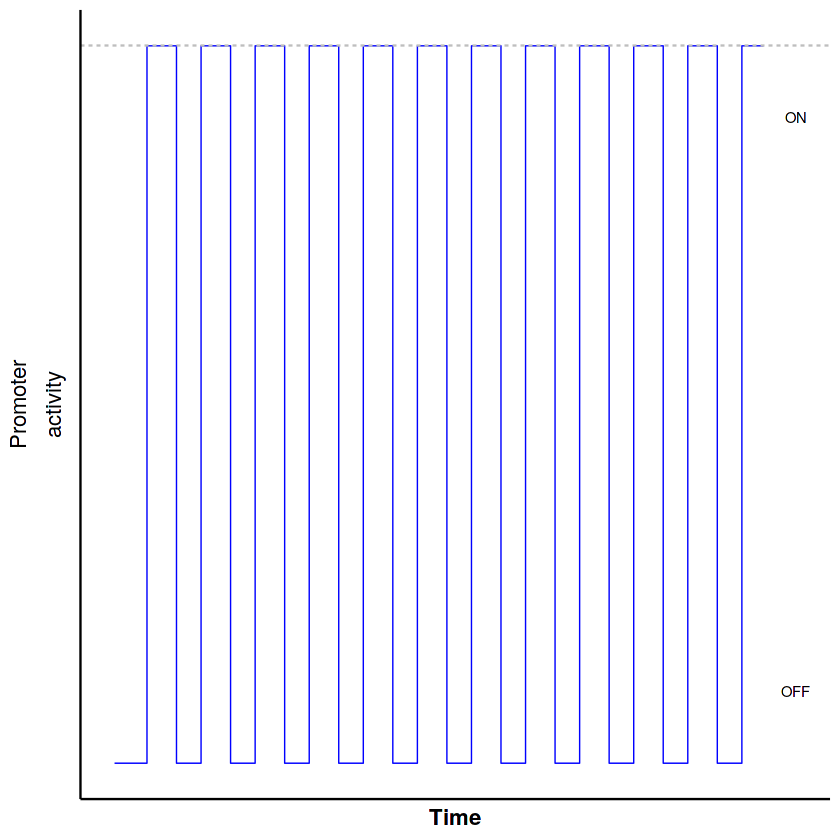

In [88]:
col <- "blue"
params = c(kon = 3/(5*3600), koff = 1/(2*3600))
on_time <- 1/(params['kon'] + params['koff'])
time_diff <- 1/(params['kon'])
num_bursts <- floor((20*3600)/time_diff)
burst_times <- 3600 + (1:num_bursts - 1)*(1/(params['kon']))
time_list <- seq(0, 20*3600, by = 1)
promoter <- rep(0, 20*3600 + 1)
for( b in 1:num_bursts ){
    id.begin <- which(time_list >= burst_times[b])
    id.end <- which(time_list <= burst_times[b] + on_time)
    if( length(id.end) != 0 ){
        promoter[id.begin[1]:id.end[length(id.end)]] <- 1
    }else{
        promoter[id.begin[1]:(20*3600 + 1)] <- 1
    }
    
}
dat.plot <- data.frame(x = time_list/3600, 
                        y = promoter)
p <- ggline(dat.plot, x = "x", y = "y", 
            numeric.x.axis = T, 
            linetype = "solid",
            plot_type = c("l"),
            fill = col,           
            color = col,
            sort.by.groups = FALSE,
            x.text.angle = 0,
            ylab = expression(atop("Promoter", 
                                   "activity")),
            xlab = "Time",
            # legend = "bottom",
            legend.title = "",
            y.text.angle = 0,
            rotate = F,
            font.x = 14, 
            font.y = 14,
            font.tickslab = 13,
            size = 0.3,
            point.size = 0.1,
            # font.label = 14,
            theme = theme_pubr()
)
# Add horizontal line for the mean value
p <- p + geom_hline(yintercept = 1, color = "gray", linetype = 2, 
                    size = 0.5)

p <- p  + 
  geom_text(data = data.frame(x = 21, y = 0.9, label = "ON"), 
            mapping = aes(x = x, y = y, label = label), color = "black", size = 3) + 
geom_text(data = data.frame(x = 21, y = 0.1, label = "OFF"), 
            mapping = aes(x = x, y = y, label = label), color = "black", size = 3)

# Remove white space between the plot and the axes
p <- p + xlim(c(0, 21))
  scale_x_continuous(limits = c(0,21), expand = c(0, 0))

# Adjust font sizes for the title and the axes
p <- p + 
  theme(plot.title = element_text(size = 15, color = "black", face="bold.italic"), 
        axis.title.x = element_text(size = 13, colour = "black", face = "bold"), 
        axis.title.y = element_text(size = 13, colour = "black", face = "bold"), 
        axis.text.x = element_blank(),
        axis.text.y = element_blank(), 
        axis.ticks.x = element_blank(), 
        axis.ticks.y = element_blank())
p.Ac.promoter <- p
print(p)

### Combine plots

In [ ]:
first.row <- plot_grid(p.Ac.time, p.Ac.hist, ncol = 2, 
                    labels = "", align = "h", rel_widths = c(1.6, 1))
second.row <- plot_grid(p.Ac.promoter, NULL, ncol = 2, labels = "", align = "h", 
                       rel_widths = c(1.6, 1))
plot.Ac <- plot_grid(first.row, second.row, nrow = 2, rel_heights = c(2.5, 1))
save_plot("Plot_Ac.png", plot.Ac, base_height = 4, base_width = 6)
# print(plot.Ac)
plot.list[[3]] <- plot.Ac

## Simulations for activator + enhancer

### Setup simulation parameters and initial state

In [90]:
# reaction rates (k_on, k_off, k_m, gamma_m, k_p, gamma_p)
rxn_rates = c(0.000625, 0.001041667, 0.208333333, 0.000115525, 0.032346868, 7.70164E-05) 

params <- c(kon = rxn_rates[1], koff = rxn_rates[2], km = rxn_rates[3], 
                   gamma_m = rxn_rates[4], kp = rxn_rates[5], gamma_p = rxn_rates[6])

# initial state vector
# initial_state <- c(Gon = 1, Goff = 0,  
#             M = floor((rxn_rates[1] * rxn_rates[3])/
#                       ((rxn_rates[1] + rxn_rates[2]) * rxn_rates[4])), 
#             P = floor((rxn_rates[5])/rxn_rates[6])*
#               floor((rxn_rates[1] * rxn_rates[3])/
#                       ((rxn_rates[1] + rxn_rates[2]) * rxn_rates[4])))

# reactions in the system
reactions <- list(reaction(~kon * Goff, c(Goff = -1, Gon = +1), "promoter_on"),  
                  reaction(~koff * Gon, c(Goff = +1, Gon = -1), "promoter_off"), 
                  reaction(~km * Gon, c(M = +1), "transcription"), 
                  reaction(~gamma_m * M, c(M = -1), "mRNA_degradation"), 
                  reaction(~kp * M, c(P = +1), "translation"), 
                  reaction(~gamma_p * P, c(P = -1), "protein_degradation"))

# num. of hours of simulation to use as burn-in
skip_hours <- 0

### Run simulation using Gillespie's Direct Method (DM)

In [25]:
out.Ac_NE <- foreach( b = 1:nboot, .options.snow = opts )%dopar%{
  set.seed(b)
  library(doParallel)
  library(GillespieSSA2)
  initial_state <- c(Gon = 1, Goff = 0,  
            M = floor((rxn_rates[1] * rxn_rates[3])/
                      ((rxn_rates[1] + rxn_rates[2]) * rxn_rates[4])), 
            P = out.NE[[b]]$Protein[length(out.NE[[b]]$Protein)])    
  out <-
    ssa(
      initial_state = initial_state,
      reactions = reactions,
      params = params,
      method = ssa_exact(),
      final_time = (20 + skip_hours) * 60 * 60,
      census_interval = 10,
      verbose = TRUE
    )
  return(list(time = out$time, Protein = out$state[, 4]))
}
save(out.Ac_NE, file = "time_series_activator_noise_enhancer_Fig1C.RData")

  |======================================================================| 100%

### Extract single-cell protein counts at the end of the simulation. Take all single-cell data from all time points; assume that the process is ergodic.

In [91]:
steady_state <- rep(0, nboot)
for( i in 1:nboot ){
  steady_state[i] <- out.Ac_NE[[i]]$Protein[length(out.Ac_NE[[i]]$Protein)]
}

### Plot for single-cell trajectories protein count

In [92]:
col <- "red" # color for the single-cell time trajectories

# Plot gray region showing threshold region for active HIV replication
dat.polygon <- data.frame(x = c(0, 20, 20, 0), 
                          y = c(3, 3, 4.5, 4.5))
p <- ggplot()
p <- p + geom_polygon(aes(x = x, y = y), data = dat.polygon, fill = "gray", 
                      col = "white", alpha = 0.5) 
# + 
#   geom_text(data = data.frame(x = 10, y = 4, label = "Active \n replication"), 
#             mapping = aes(x = x, y = y, label = label), color = "white", size = 5)

#Add all the time trajectors to the plot
id.sample <- 1:nboot
for( b in id.sample ){
  id <- which(out.Ac_NE[[b]]$time >= skip_hours * 60 * 60)
  dat.plot <- data.frame(x = out.Ac_NE[[b]]$time[id]/(60 * 60) - 
                           min(out.Ac_NE[[1]]$time[id]/(60 * 60)), 
                         y = out.Ac_NE[[b]]$Protein[id]/10^5)
  p <- p + geom_line(data = dat.plot, mapping = aes(x = x, y = y), color = col, 
                     linetype = 1, size = 0.3)
}

# Add horizontal line for the mean value
p <- p + geom_hline(yintercept = mean_val/10^5, color = "gray", linetype = 2, 
                    size = 1.3)

# Write 'Mean' above the mean horizontal line
# p <- p + 
# geom_text(data = data.frame(x = 10, y = 1, label = "Mean"), 
#             mapping = aes(x = x, y = y, label = label), color = "white", size = 5)

# Remove white space between the plot and the axes
p <- p + ylim(c(0, 4.5)) + 
  scale_x_continuous(limits = c(0,20), expand = c(0, 0)) +
  scale_y_continuous(limits = c(0,4.5), expand = c(0, 0))

# Add axes labels
p <- p + xlab("Time (hrs)") + ylab(expression(atop("Gene product", 
                                   "(molecules" %*% "10"^"5"*")")))

# Adjust font sizes for the title and the axes
p <- p + 
  theme(plot.title = element_text(size = 16, color = "black", face="bold.italic"), 
        axis.title.x = element_text(size = 14, colour = "black", face = "bold"), 
        axis.title.y = element_text(size = 14, colour = "black", face = "bold"), 
        axis.text.x = element_text(size = 13, colour = "black"), 
        axis.text.y = element_text(size = 13, colour = "black"), 
        panel.background = element_blank(),
        axis.line.y = element_line(color = "black"), axis.line.x = element_line(color = "black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank())
p.Ac_NE.time <- p +  ggtitle("Activator + noise enhancer")

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



### Histogram for protein count at the end of simulation

In [93]:
# y-axis limit
ymax <- 70
ymid <- 40

# Draw a gray region which defines region of active HIV replication
dat.polygon <- data.frame(y = c(0, ymax, ymax, 0), 
                          x = c(3, 3, 4.5, 4.5))
p <- ggplot() + geom_polygon(aes(x = x, y = y), data = dat.polygon, fill = "gray", 
                      col = "white", alpha = 0.5)

# Save single-cell protein count data at the end of simulation in a data frame
dat.plot <- data.frame(x = steady_state/10^5)

# Plot histogram
p <- p + 
  geom_histogram(data = dat.plot, mapping = aes(x = x), 
                 color=col, fill=col, bins = 50) + coord_flip()

# Remove white space between the plot and the axes
p <- p + xlim(c(0, 4.5)) + 
  scale_x_continuous(limits = c(0,4.5), expand = c(0, 0)) + 
  scale_y_continuous(limits = c(0,ymax), expand = c(0, 0))

# Remove background and axes text
p <- p + 
  theme(axis.title.x = element_blank(), 
        axis.title.y = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_blank(), 
        axis.ticks.x = element_blank(), 
        axis.ticks.y = element_blank(), 
        panel.background = element_blank(), axis.line.y = element_line(), 
        panel.grid.major = element_blank(), panel.grid.minor = element_blank())

# Add horizontal line for the mean value
p <- p + geom_vline(xintercept = mean_val/10^5, color = "gray", linetype = 2, 
                    size = 1.3)


# Visually explain the concept of noise
# p <- p + geom_segment(aes(x = 0, y = ymid, 
#                           xend = 0.3, yend = ymid),
#                       arrow = arrow(length = unit(0.3, "cm")), size = 0.7)
# p <- p + geom_segment(aes(x = 1.3, y = ymid, 
#                           xend = 1, yend = ymid),
#                       arrow = arrow(length = unit(0.3, "cm")), size = 0.7) + 
#   geom_text(data = data.frame(x = 1.5, y = ymid, label = "Noise"), 
#             mapping = aes(x = x, y = y, label = label), color = "black", size = 5)
p.Ac_NE.hist <- p

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



### Representative plot of promoter activity

<ScaleContinuousPosition>
 Range:  
 Limits:    0 --   20

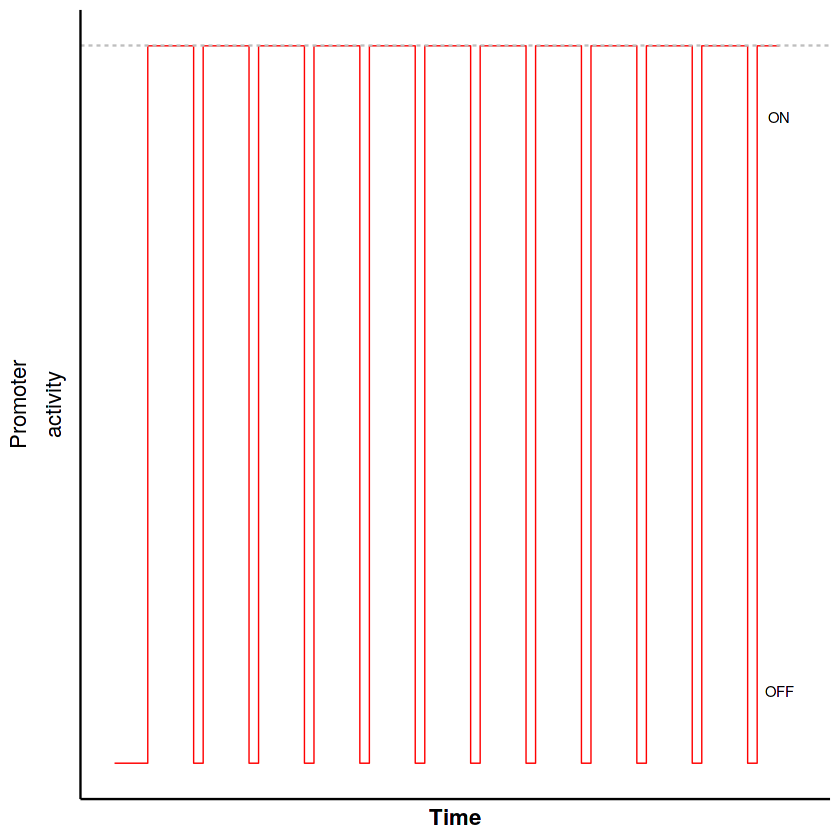

In [95]:
col <- "red"
params = c(kon = 3/(5*3600), koff = 0.5/(4*3600))
on_frac = (params['kon'])/(params['kon'] + params['koff'])
on_time <- 1/(params['kon'] + params['koff'])
time_diff <- 1/(params['kon'])
num_bursts <- floor((20*3600)/time_diff)
burst_times <- 3600 + (1:num_bursts - 1)*(1/(params['kon']))
time_list <- seq(0, 20*3600, by = 1)
promoter <- rep(0, 20*3600 + 1)
for( b in 1:num_bursts ){
    id.begin <- which(time_list >= burst_times[b])
    id.end <- which(time_list <= burst_times[b] + on_time)
    if( length(id.end) != 0 ){
        promoter[id.begin[1]:id.end[length(id.end)]] <- 1
    }else{
        promoter[id.begin[1]:(20*3600 + 1)] <- 1
    }
    
}
dat.plot <- data.frame(x = time_list/3600, 
                        y = promoter)
p <- ggline(dat.plot, x = "x", y = "y", 
            numeric.x.axis = T, 
            linetype = "solid",
            plot_type = c("l"),
            fill = col,           
            color = col,
            sort.by.groups = FALSE,
            x.text.angle = 0,
            ylab = expression(atop("Promoter", 
                                   "activity")),
            xlab = "Time",
            # legend = "bottom",
            legend.title = "",
            y.text.angle = 0,
            rotate = F,
            font.x = 14, 
            font.y = 14,
            font.tickslab = 13,
            size = 0.3,
            point.size = 0.1,
            # font.label = 14,
            theme = theme_pubr()
)
# Add horizontal line for the mean value
p <- p + geom_hline(yintercept = 1, color = "gray", linetype = 2, 
                    size = 0.5)

p <- p  + 
  geom_text(data = data.frame(x = 20, y = 0.9, label = "ON"), 
            mapping = aes(x = x, y = y, label = label), color = "black", size = 3) + 
geom_text(data = data.frame(x = 20, y = 0.1, label = "OFF"), 
            mapping = aes(x = x, y = y, label = label), color = "black", size = 3)

# Remove white space between the plot and the axes
p <- p + xlim(c(0, 20.5))
  scale_x_continuous(limits = c(0,20), expand = c(0, 0))

# Adjust font sizes for the title and the axes
p <- p + 
  theme(plot.title = element_text(size = 15, color = "black", face="bold.italic"), 
        axis.title.x = element_text(size = 13, colour = "black", face = "bold"), 
        axis.title.y = element_text(size = 13, colour = "black", face = "bold"), 
        axis.text.x = element_blank(),
        axis.text.y = element_blank(), 
        axis.ticks.x = element_blank(), 
        axis.ticks.y = element_blank())
p.Ac_NE.promoter <- p
print(p)

### Combine plots

In [ ]:
first.row <- plot_grid(p.Ac_NE.time, p.Ac_NE.hist, ncol = 2, 
                    labels = "", align = "h", rel_widths = c(1.6, 1))
second.row <- plot_grid(p.Ac_NE.promoter, NULL, ncol = 2, labels = "", align = "h", 
                       rel_widths = c(1.6, 1))
plot.Ac_NE <- plot_grid(first.row, second.row, nrow = 2, rel_heights = c(2.5, 1))
save_plot("Plot_Ac_NE.png", plot.Ac_NE, base_height = 4, base_width = 6)
# print(plot.Ac_NE)
plot.list[[4]] <- plot.Ac_NE

### Make composite Fig. 1C

In [97]:
plot.full <- plot_grid(plot.list[[1]], plot.list[[2]], plot.list[[3]], plot.list[[4]], nrow = 2, 
                      labels = NULL)
save_plot("Plot_Fig_1C.png", plot.full, base_height = 8, base_width = 12)

## Close Parallel Cluster

In [ ]:
close(pb)
stopCluster(cl)

# Fig. 1D--Heatmap in the noise-vs-mean space for varying burst size and burst frequency over a 2D grid. Simulations done for burst frequency modulation with burst size fixed. Burst size modulated by changing $k_m$

In [3]:
# Factors by which burst frequency changes
a_vec = c(1/(seq(10, 2, by = -2)), 1, seq(2, 10, by = 2))

# burst size values
burst_size <- c(1, 10, 50, 100, 500, 1000, 5000)

In [4]:
# reactions in the system
reactions <- list(reaction(~kon * Goff, c(Goff = -1, Gon = +1), "promoter_on"),  
                  reaction(~koff * Gon, c(Goff = +1, Gon = -1), "promoter_off"), 
                  reaction(~km * Gon, c(M = +1), "transcription"), 
                  reaction(~gamma_m * M, c(M = -1), "mRNA_degradation"), 
                  reaction(~kp * M, c(P = +1), "translation"), 
                  reaction(~gamma_p * P, c(P = -1), "protein_degradation"))

# num. of hours of simulation to use as burn-in
skip_hours <- 0

### Run simulations for varying burst frequency and fixed burst size

In [ ]:
# reaction rates for untreated (k_on, k_off, k_m, gamma_m, k_p, gamma_p)
rxn_rates_init = c(0.000208333, 0.002083333, 0.208333333, 0.000115525, 0.032346868, 7.70164E-05)

for( i in 1:length(burst_size) ){
    for( cl.id in 1:4 ){
        id.begin <- 1 + (cl.id - 1)*3
        if( cl.id < 4 ){
            id.end <- (id.begin + 2)
        }else{
            id.end <- (id.begin + 1)
        }
        ## Create cluster
        num_cores = 10 # num. of cores to use
        nboot <- 1000 # num. of cells to simulate
        cl <- makeCluster(num_cores) # create clusters
        registerDoSNOW(cl) # register clusters
        # clusterEvalQ(cl, .libPaths("/home/atheistpoet/R/x86_64-pc-linux-gnu-library/4.0"))
        clusterCall(cl, function() {
            lib.paths <- "/home/atheistpoet/R/x86_64-pc-linux-gnu-library/4.0" # R library path
            .libPaths(lib.paths)
            library(GillespieSSA2)
        })
        pb <- txtProgressBar(max = nboot, style = 3) # to display progress bars for parallel computation
        progress <- function(n) setTxtProgressBar(pb, n) # to display progress bars for parallel computation
        opts <- list(progress = progress) # to display progress bars for parallel computation
        ## Create cluster
        for( j in id.begin:id.end ){
            message("i = ", i, " j = ", j)
            # Setup simulation parameters and initial state
            rxn_rates = rxn_rates_init
            rxn_rates[1] = rxn_rates[1] * a_vec[j]
            rxn_rates[3] = rxn_rates[2]*burst_size[i]

            params <- c(kon = rxn_rates[1], koff = rxn_rates[2], km = rxn_rates[3], 
                               gamma_m = rxn_rates[4], kp = rxn_rates[5], gamma_p = rxn_rates[6])

            # initial state vector
            initial_state <- c(Gon = 1, Goff = 0,  
                        M = floor((rxn_rates[1] * rxn_rates[3])/
                                  ((rxn_rates[1] + rxn_rates[2]) * rxn_rates[4])), 
                        P = floor((rxn_rates[5])/rxn_rates[6])*
                          floor((rxn_rates[1] * rxn_rates[3])/
                                  ((rxn_rates[1] + rxn_rates[2]) * rxn_rates[4])))

            out.sim.heatmap <- foreach( b = 1:nboot, .options.snow = opts )%dopar%{
              set.seed(b)
              out <-
                ssa(
                  initial_state = initial_state,
                  reactions = reactions,
                  params = params,
                  method = ssa_exact(),
                  final_time = (20 + skip_hours) * 60 * 60,
                  census_interval = 10,
                  verbose = TRUE
                )
    #           detach("package:GillespieSSA2", unload=TRUE)
              return(list(time = out$time, Protein = out$state[, 4], promoter = out$state[, 1]))
            }
            save(out.sim.heatmap, file = paste("burst_size_fixed_k_m/time_trajectory_single_cell_kon_factor_idx_", j, 
                                              "_burst_size_idx_", i, ".RData", sep = ""))
        }
        ## End cluster
        close(pb)
        stopCluster(cl)
        ## End cluster
    }

}



### Read simulation data

In [ ]:
mat_perc_cells2 <- matrix(0, length(burst_size), length(a_vec)) # matrix for %cells crossing 
                                                                                   # threshold
mean_mat <- noise_mat <- matrix(0, length(burst_size), length(a_vec)) # matrix to store mean and noise values
burst_size_lim <- length(burst_size)
for( i in 1:burst_size_lim ){
  message("burst size loop = ", i)
  for( j in 1:length(a_vec) ){
      # load the time series data
      load(paste("burst_size_fixed_k_m/time_trajectory_single_cell_kon_factor_idx_", j, 
               "_burst_size_idx_", i, ".RData", sep = ""))
      
    rxn_rates = rxn_rates_init
    rxn_rates[1] = rxn_rates[1] * a_vec[j]
    rxn_rates[3] = rxn_rates[2]*burst_size[i]
     
#     Analytical mean  
#     mean_mat[i, j] = ((rxn_rates[5])/rxn_rates[6])*
#       ((rxn_rates[1] * rxn_rates[3])/((rxn_rates[2] + rxn_rates[1]) * rxn_rates[4]))
    count1 <- count2 <- 0
    P_count <- rep(0, nboot)
    for( b in 1:nboot ){
      id <- which(out.sim.heatmap[[b]]$Protein > 3*10^5 )
      if( length(id) > 0 ){
        count2 <- count2 + 1
      }
      P_count[b] <- out.sim.heatmap[[b]]$Protein[length(out.sim.heatmap[[b]]$Protein)]
    }
    mat_perc_cells2[i, j] <- count2/nboot
    
#     Simulation mean 
    mean_mat[i, j] <- mean(P_count)
    noise_mat[i, j] <- var(P_count)/(mean(P_count)^2)
  }
}

### Plot heatmap

In [ ]:
# Data frame for the noise-space data
dat.plot <- data.frame(mean = c(mean_mat[(1:burst_size_lim), ]), 
                       noise = c(noise_mat[(1:burst_size_lim), ]), 
                       perc_cells = c(mat_perc_cells2[(1:burst_size_lim), ])*100)

# Empty plot
p <- ggplot()
# Variables for model lines
slope.vec <- intercept.vec <- rep(0, length(burst_size))
for( i in (1:burst_size_lim) ){
    
    # Compute model line
    dat <- data.frame(x = log10(mean_mat[i, ]), y = log10(noise_mat[i, ]))
    mdl <- lm(y ~ x, data = dat)
    intercept.vec[i] <- intercept <- mdl$coefficients[1]
    slope.vec[i] <- slope <- mdl$coefficients[2]
    
    # Plot model line
    p <- p + geom_abline(intercept = intercept, slope = slope, linetype = 2,
                           size = 0.4, color = "gray30")
}

# Annotate untreated
p <- p + geom_text(data = data.frame(x = mean_mat[4, 6]*10^0.15,
                                     y = noise_mat[4, 6]*10^0.015, label = "Untreated"), 
                   mapping = aes(x = x, y = y, label = label), color = "blue", size = 3, 
                   angle = atan(slope.vec[4])*180/pi - 10)

# Fill points by percentage of cells crossing active replication threshold
p <- p + geom_point(data = dat.plot, mapping = aes(x = mean, y = noise, fill = perc_cells), 
                    size = 3, alpha = 1, colour="black", pch = 21) +
  theme_bw() + scale_fill_gradient2(low="white", mid = "blue", high="red", 
                                    midpoint = 50, name = "%cells")

# Annotate model lines by burst size values
for( i in (1:burst_size_lim) ){
  if( i != 1 ){
    if( i != 3 & i != 5 ){
      p <- p + geom_text(data = data.frame(x = mean_mat[i, 2]*10^0.2, y = noise_mat[i, 2]), 
                         label = TeX(sprintf('burst size = %d$', burst_size[i])),
                         mapping = aes(x = x, y = y, label = label), color = "black", size = 3, 
                         angle = atan(slope.vec[i])*180/pi - 10)
    }else{
      p <- p + geom_text(data = data.frame(x = mean_mat[i, 2]*10^-0.2, y = noise_mat[i, 2]), 
                         label = TeX(sprintf('burst size = %d$', burst_size[i])),
                         mapping = aes(x = x, y = y, label = label), color = "black", size = 3, 
                         angle = atan(slope.vec[i])*180/pi - 10)
    }
  }else{
    p <- p + geom_text(data = data.frame(x = mean_mat[i, 4]*10^0.2, y = noise_mat[i, 4]), 
                       label = TeX(sprintf('burst size = %d$', burst_size[i])),
                       mapping = aes(x = x, y = y, label = label), color = "black", size = 3, 
                       angle = atan(slope.vec[i])*180/pi - 10)
  }
}

# changes axes to log10 scale
p <- p + scale_x_log10(breaks = trans_breaks("log10", function(x) 10^x),
                       labels = trans_format("log10", math_format(10^.x))) +
  scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),
                labels = trans_format("log10", math_format(10^.x))) +
  annotation_logticks() 
# + coord_cartesian(ylim=c(0.01,10))


# Remove white space between the plot and the axes
# p <- p + 
#   scale_x_continuous(limits = c(10^4.8,10^5.8), expand = c(0, 0)) +
#   scale_y_continuous(limits = c(10^-2,10^0.3), expand = c(0, 0))

# Add axes labels
p <- p + xlab(TeX('$<Gene\\; product>$')) + 
  ylab(TeX('$CV^2$'))



# Adjust font sizes for the title and the axes
p <- p + 
  theme(plot.title = element_text(size = 16, color = "black", face="bold.italic"), 
        axis.title.x = element_text(size = 14, colour = "black", face = "bold"), 
        axis.title.y = element_text(size = 14, colour = "black", face = "bold"), 
        axis.text.x = element_text(size = 13, colour = "black"), 
        axis.text.y = element_text(size = 13, colour = "black"), 
        panel.background = element_blank(), 
        axis.line.y = element_line(color = "black"), axis.line.x = element_line(color = "black"),
        # panel.grid.major = element_blank(), panel.grid.minor = element_blank(), 
        legend.title = element_text(color = "black", size = 16), 
        legend.text = element_text(color = "black", size = 14))
# save_plot("Plot_perc_cells_noise_space_any_crossing_burst_size_change_by_k_m.png", 
#           p, base_height = 4, base_width = 6)
# print(p)
save_plot("A_temp_plot.png", 
          p, base_height = 4, base_width = 6)